In [8]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [9]:
sp500 = pd.read_csv('../data/sp500_stock_prices_2000_2025.csv', parse_dates=['Date'], skiprows=[1]).drop(columns=['Adj Close', 'Volume'])
sp500.set_index('Date', inplace=True)
ibm = pd.read_csv('../data/ibm_stock_prices_2000_2025.csv', parse_dates=['Date'], skiprows=[1]).drop(columns=['Adj Close', 'Volume'])
ibm.set_index('Date', inplace=True)

In [10]:
def create_sequence(data: pd.DataFrame, seq_length: int):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length, :])
        y.append(data.iloc[i + seq_length, 3])
    return np.array(X), np.array(y)

#define model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])
    return out

In [13]:
def train_model(model, criterion, optimizer, x_train, y_train, epochs=10, batch_size=30):
    model.to(device)  # Đẩy model lên GPU
    model.train()

    # Đảm bảo dữ liệu là tensor và nằm trên GPU
    x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

    for epoch in range(epochs):
        total_loss = 0.0
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (len(x_train) // batch_size)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')


In [14]:
def evaluate_model(neurons, opt, x_train, y_train, x_test, y_test, epochs=10, batch_size=30):
    model = LSTMModel(input_size=4, hidden_size=neurons, output_size=1).to(device)  # đẩy model lên GPU
    criterion = nn.MSELoss()

    if opt == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # Huấn luyện
    train_model(model, criterion, optimizer, x_train, y_train, epochs=epochs, batch_size=batch_size)

    # Chuyển sang chế độ đánh giá
    model.eval()
    with torch.no_grad():
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
        y_pred = model(x_test_tensor)
        mse = criterion(y_pred, y_test_tensor)

    return mse.item(), model


In [15]:
import time
# Real
seq_lengths = [15, 20, 30, 50]
# Test
# seq_lengths = [15]
logger = []
num_features = 4
i = 0
for ticker, df in zip(['SP500', 'IBM'], [sp500.copy(), ibm.copy()]):
    for seq_length in seq_lengths:
        X,y = create_sequence(df, seq_length)
        train_size = int(len(df)*0.8)
        X_train, X_test = X[0:train_size, :], X[train_size:, :]
        y_train, y_test = y[0:train_size], y[train_size:]
        scalerX = MinMaxScaler(feature_range =(0,1))
        scalery = MinMaxScaler(feature_range = (0,1))

        x_train = scalerX.fit_transform(X_train.reshape(-1, num_features*seq_length))
        x_test = scalerX.transform(X_test.reshape(-1, num_features*seq_length))
        y_train = scalery.fit_transform(y_train.reshape(-1,1))
        y_test = scalery.transform(y_test.reshape(-1,1))
        x_train = torch.from_numpy(x_train.reshape(-1, seq_length, num_features)).float()
        x_test = torch.from_numpy(x_test.reshape(-1, seq_length, num_features)).float()
        y_train = torch.from_numpy(y_train).float()
        y_test = torch.from_numpy(y_test).float()
        print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
        best_mse = float('inf')
        best_params = {}
        # Real
        neurons = [200,500,800, 1000]
        # Test
        # neurons = [50]
        optimizers = ['adam', 'sgd']

        for n in neurons:
            for opt in optimizers:
                starttime = time.time()
                mse, model = evaluate_model(n, opt, x_train, y_train, x_test, y_test, epochs=10, batch_size=128)
                print(f'Ticker: {ticker}, Length: {seq_length}, Neurons: {n}, Optimizer: {opt}, MSE: {mse}')
                logger.append({
                    'seq_length': seq_length,
                    'neurons': n,
                    'optimizer': opt,
                    'mse': mse,
                    'ticker': ticker,
                    'model_state_dict': model.state_dict()
                })
                i = i + 1
                endtime = time.time()
                print(f'epoch {i}, time taken: {endtime - starttime:.2f} seconds')

torch.Size([5095, 15, 4]) torch.Size([1259, 15, 4]) torch.Size([5095, 1]) torch.Size([1259, 1])


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 0.0114
Epoch [2/10], Loss: 0.0273
Epoch [3/10], Loss: 0.0264
Epoch [4/10], Loss: 0.0235
Epoch [5/10], Loss: 0.0450
Epoch [6/10], Loss: 0.0286
Epoch [7/10], Loss: 0.0623
Epoch [8/10], Loss: 0.0787
Epoch [9/10], Loss: 0.0290
Epoch [10/10], Loss: 0.0262
Ticker: SP500, Length: 15, Neurons: 200, Optimizer: adam, MSE: 0.160945862531662
epoch 1, time taken: 4.25 seconds


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 0.0857
Epoch [2/10], Loss: 0.0367
Epoch [3/10], Loss: 0.0349
Epoch [4/10], Loss: 0.0339
Epoch [5/10], Loss: 0.0320
Epoch [6/10], Loss: 0.0298
Epoch [7/10], Loss: 0.0275
Epoch [8/10], Loss: 0.0254
Epoch [9/10], Loss: 0.0233
Epoch [10/10], Loss: 0.0212
Ticker: SP500, Length: 15, Neurons: 200, Optimizer: sgd, MSE: 0.36910736560821533
epoch 2, time taken: 1.44 seconds
Epoch [1/10], Loss: 0.1448
Epoch [2/10], Loss: 0.0608
Epoch [3/10], Loss: 0.0698
Epoch [4/10], Loss: 0.0784
Epoch [5/10], Loss: 0.0717
Epoch [6/10], Loss: 0.0705
Epoch [7/10], Loss: 0.0719
Epoch [8/10], Loss: 0.0723
Epoch [9/10], Loss: 0.0722
Epoch [10/10], Loss: 0.0721
Ticker: SP500, Length: 15, Neurons: 500, Optimizer: adam, MSE: 0.2592921853065491
epoch 3, time taken: 2.34 seconds
Epoch [1/10], Loss: 0.0898
Epoch [2/10], Loss: 0.0397
Epoch [3/10], Loss: 0.0380
Epoch [4/10], Loss: 0.0371
Epoch [5/10], Loss: 0.0353
Epoch [6/10], Loss: 0.0332
Epoch [7/10], Loss: 0.0310
Epoch [8/10], Loss: 0.0289
Epoch [9/1

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)


Epoch [2/10], Loss: 0.0297
Epoch [3/10], Loss: 0.0931
Epoch [4/10], Loss: 0.0326
Epoch [5/10], Loss: 0.0267
Epoch [6/10], Loss: 0.0102
Epoch [7/10], Loss: 0.0014
Epoch [8/10], Loss: 0.0007
Epoch [9/10], Loss: 0.0006
Epoch [10/10], Loss: 0.0019
Ticker: SP500, Length: 20, Neurons: 200, Optimizer: adam, MSE: 0.06193852052092552
epoch 9, time taken: 1.67 seconds
Epoch [1/10], Loss: 0.0874


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


Epoch [2/10], Loss: 0.0415
Epoch [3/10], Loss: 0.0400
Epoch [4/10], Loss: 0.0390
Epoch [5/10], Loss: 0.0371
Epoch [6/10], Loss: 0.0348
Epoch [7/10], Loss: 0.0326
Epoch [8/10], Loss: 0.0303
Epoch [9/10], Loss: 0.0282
Epoch [10/10], Loss: 0.0261
Ticker: SP500, Length: 20, Neurons: 200, Optimizer: sgd, MSE: 0.4629397690296173
epoch 10, time taken: 1.57 seconds
Epoch [1/10], Loss: 1.5538
Epoch [2/10], Loss: 0.6392
Epoch [3/10], Loss: 0.0401
Epoch [4/10], Loss: 0.0627
Epoch [5/10], Loss: 0.0581
Epoch [6/10], Loss: 0.0642
Epoch [7/10], Loss: 0.0790
Epoch [8/10], Loss: 0.0928
Epoch [9/10], Loss: 0.1017
Epoch [10/10], Loss: 0.1055
Ticker: SP500, Length: 20, Neurons: 500, Optimizer: adam, MSE: 0.20389175415039062
epoch 11, time taken: 2.90 seconds
Epoch [1/10], Loss: 0.0945
Epoch [2/10], Loss: 0.0406
Epoch [3/10], Loss: 0.0385
Epoch [4/10], Loss: 0.0374
Epoch [5/10], Loss: 0.0354
Epoch [6/10], Loss: 0.0331
Epoch [7/10], Loss: 0.0308
Epoch [8/10], Loss: 0.0285
Epoch [9/10], Loss: 0.0263
Epoch [1

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 0.0561
Epoch [2/10], Loss: 0.0404
Epoch [3/10], Loss: 0.0700
Epoch [4/10], Loss: 0.1160
Epoch [5/10], Loss: 0.0753
Epoch [6/10], Loss: 0.0855
Epoch [7/10], Loss: 0.1130
Epoch [8/10], Loss: 0.1070
Epoch [9/10], Loss: 0.4004
Epoch [10/10], Loss: 0.4180
Ticker: SP500, Length: 30, Neurons: 200, Optimizer: adam, MSE: 0.2946585714817047
epoch 17, time taken: 4.03 seconds


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 0.0830
Epoch [2/10], Loss: 0.0390
Epoch [3/10], Loss: 0.0373
Epoch [4/10], Loss: 0.0361
Epoch [5/10], Loss: 0.0340
Epoch [6/10], Loss: 0.0316
Epoch [7/10], Loss: 0.0292
Epoch [8/10], Loss: 0.0269
Epoch [9/10], Loss: 0.0247
Epoch [10/10], Loss: 0.0225
Ticker: SP500, Length: 30, Neurons: 200, Optimizer: sgd, MSE: 0.39032697677612305
epoch 18, time taken: 4.12 seconds
Epoch [1/10], Loss: 1.5780
Epoch [2/10], Loss: 0.0457
Epoch [3/10], Loss: 0.0658
Epoch [4/10], Loss: 0.0761
Epoch [5/10], Loss: 0.0912
Epoch [6/10], Loss: 0.0936
Epoch [7/10], Loss: 0.0847
Epoch [8/10], Loss: 0.0688
Epoch [9/10], Loss: 0.0494
Epoch [10/10], Loss: 0.0294
Ticker: SP500, Length: 30, Neurons: 500, Optimizer: adam, MSE: 0.008902094326913357
epoch 19, time taken: 5.29 seconds
Epoch [1/10], Loss: 0.0927
Epoch [2/10], Loss: 0.0422
Epoch [3/10], Loss: 0.0403
Epoch [4/10], Loss: 0.0392
Epoch [5/10], Loss: 0.0372
Epoch [6/10], Loss: 0.0348
Epoch [7/10], Loss: 0.0325
Epoch [8/10], Loss: 0.0302
Epoch 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 0.0174
Epoch [2/10], Loss: 0.0203
Epoch [3/10], Loss: 0.0294
Epoch [4/10], Loss: 0.0277
Epoch [5/10], Loss: 0.0247
Epoch [6/10], Loss: 0.0210
Epoch [7/10], Loss: 0.0162
Epoch [8/10], Loss: 0.0144
Epoch [9/10], Loss: 0.0124
Epoch [10/10], Loss: 0.0082
Ticker: SP500, Length: 50, Neurons: 200, Optimizer: adam, MSE: 0.07391416281461716
epoch 25, time taken: 4.97 seconds


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 0.0908
Epoch [2/10], Loss: 0.0384
Epoch [3/10], Loss: 0.0363
Epoch [4/10], Loss: 0.0352
Epoch [5/10], Loss: 0.0331
Epoch [6/10], Loss: 0.0308
Epoch [7/10], Loss: 0.0284
Epoch [8/10], Loss: 0.0260
Epoch [9/10], Loss: 0.0238
Epoch [10/10], Loss: 0.0216
Ticker: SP500, Length: 50, Neurons: 200, Optimizer: sgd, MSE: 0.3647058308124542
epoch 26, time taken: 4.54 seconds
Epoch [1/10], Loss: 1.4281
Epoch [2/10], Loss: 0.0317
Epoch [3/10], Loss: 0.0603
Epoch [4/10], Loss: 0.0632
Epoch [5/10], Loss: 0.0721
Epoch [6/10], Loss: 0.0942
Epoch [7/10], Loss: 0.0851
Epoch [8/10], Loss: 0.1006
Epoch [9/10], Loss: 0.1204
Epoch [10/10], Loss: 0.1040
Ticker: SP500, Length: 50, Neurons: 500, Optimizer: adam, MSE: 0.2572431266307831
epoch 27, time taken: 6.84 seconds
Epoch [1/10], Loss: 0.0889
Epoch [2/10], Loss: 0.0441
Epoch [3/10], Loss: 0.0425
Epoch [4/10], Loss: 0.0414
Epoch [5/10], Loss: 0.0393
Epoch [6/10], Loss: 0.0369
Epoch [7/10], Loss: 0.0344
Epoch [8/10], Loss: 0.0320
Epoch [9/

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)


Epoch [2/10], Loss: 0.0118
Epoch [3/10], Loss: 0.0269
Epoch [4/10], Loss: 0.0312
Epoch [5/10], Loss: 0.0422
Epoch [6/10], Loss: 0.0458
Epoch [7/10], Loss: 0.0435
Epoch [8/10], Loss: 0.0536
Epoch [9/10], Loss: 0.0430
Epoch [10/10], Loss: 0.0395
Ticker: IBM, Length: 15, Neurons: 200, Optimizer: adam, MSE: 0.027254275977611542
epoch 33, time taken: 1.51 seconds
Epoch [1/10], Loss: 0.1123


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


Epoch [2/10], Loss: 0.0438
Epoch [3/10], Loss: 0.0403
Epoch [4/10], Loss: 0.0388
Epoch [5/10], Loss: 0.0366
Epoch [6/10], Loss: 0.0343
Epoch [7/10], Loss: 0.0319
Epoch [8/10], Loss: 0.0297
Epoch [9/10], Loss: 0.0275
Epoch [10/10], Loss: 0.0254
Ticker: IBM, Length: 15, Neurons: 200, Optimizer: sgd, MSE: 0.02883472479879856
epoch 34, time taken: 1.43 seconds
Epoch [1/10], Loss: 0.5378
Epoch [2/10], Loss: 0.0230
Epoch [3/10], Loss: 0.0388
Epoch [4/10], Loss: 0.0389
Epoch [5/10], Loss: 0.0394
Epoch [6/10], Loss: 0.0439
Epoch [7/10], Loss: 0.0446
Epoch [8/10], Loss: 0.0447
Epoch [9/10], Loss: 0.0447
Epoch [10/10], Loss: 0.0447
Ticker: IBM, Length: 15, Neurons: 500, Optimizer: adam, MSE: 0.05959639698266983
epoch 35, time taken: 2.31 seconds
Epoch [1/10], Loss: 0.1227
Epoch [2/10], Loss: 0.0409
Epoch [3/10], Loss: 0.0367
Epoch [4/10], Loss: 0.0352
Epoch [5/10], Loss: 0.0330
Epoch [6/10], Loss: 0.0307
Epoch [7/10], Loss: 0.0284
Epoch [8/10], Loss: 0.0261
Epoch [9/10], Loss: 0.0240
Epoch [10/1

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)


Epoch [2/10], Loss: 0.0105
Epoch [3/10], Loss: 0.0184
Epoch [4/10], Loss: 0.0298
Epoch [5/10], Loss: 0.0318
Epoch [6/10], Loss: 0.0484
Epoch [7/10], Loss: 0.0479
Epoch [8/10], Loss: 0.0464
Epoch [9/10], Loss: 0.0510
Epoch [10/10], Loss: 0.0518
Ticker: IBM, Length: 20, Neurons: 200, Optimizer: adam, MSE: 0.03930777311325073
epoch 41, time taken: 2.56 seconds


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 0.1088
Epoch [2/10], Loss: 0.0402
Epoch [3/10], Loss: 0.0370
Epoch [4/10], Loss: 0.0351
Epoch [5/10], Loss: 0.0327
Epoch [6/10], Loss: 0.0301
Epoch [7/10], Loss: 0.0276
Epoch [8/10], Loss: 0.0253
Epoch [9/10], Loss: 0.0230
Epoch [10/10], Loss: 0.0208
Ticker: IBM, Length: 20, Neurons: 200, Optimizer: sgd, MSE: 0.022704152390360832
epoch 42, time taken: 2.31 seconds
Epoch [1/10], Loss: 1.2705
Epoch [2/10], Loss: 0.0412
Epoch [3/10], Loss: 0.0490
Epoch [4/10], Loss: 0.0496
Epoch [5/10], Loss: 0.0431
Epoch [6/10], Loss: 0.0381
Epoch [7/10], Loss: 0.0363
Epoch [8/10], Loss: 0.0337
Epoch [9/10], Loss: 0.0336
Epoch [10/10], Loss: 0.0328
Ticker: IBM, Length: 20, Neurons: 500, Optimizer: adam, MSE: 0.11821366101503372
epoch 43, time taken: 2.94 seconds
Epoch [1/10], Loss: 0.1136
Epoch [2/10], Loss: 0.0396
Epoch [3/10], Loss: 0.0360
Epoch [4/10], Loss: 0.0345
Epoch [5/10], Loss: 0.0325
Epoch [6/10], Loss: 0.0302
Epoch [7/10], Loss: 0.0280
Epoch [8/10], Loss: 0.0259
Epoch [9/1

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 0.2752
Epoch [2/10], Loss: 0.0693
Epoch [3/10], Loss: 0.0340
Epoch [4/10], Loss: 0.0314
Epoch [5/10], Loss: 0.0412
Epoch [6/10], Loss: 0.0770
Epoch [7/10], Loss: 0.0649
Epoch [8/10], Loss: 0.0316
Epoch [9/10], Loss: 0.0280
Epoch [10/10], Loss: 0.0352
Ticker: IBM, Length: 30, Neurons: 200, Optimizer: adam, MSE: 0.13276469707489014
epoch 49, time taken: 1.88 seconds


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 0.1181
Epoch [2/10], Loss: 0.0403
Epoch [3/10], Loss: 0.0361
Epoch [4/10], Loss: 0.0343
Epoch [5/10], Loss: 0.0319
Epoch [6/10], Loss: 0.0294
Epoch [7/10], Loss: 0.0270
Epoch [8/10], Loss: 0.0246
Epoch [9/10], Loss: 0.0223
Epoch [10/10], Loss: 0.0202
Ticker: IBM, Length: 30, Neurons: 200, Optimizer: sgd, MSE: 0.02231507934629917
epoch 50, time taken: 1.77 seconds
Epoch [1/10], Loss: 1.2907
Epoch [2/10], Loss: 0.0527
Epoch [3/10], Loss: 0.0448
Epoch [4/10], Loss: 0.0339
Epoch [5/10], Loss: 0.0338
Epoch [6/10], Loss: 0.0472
Epoch [7/10], Loss: 0.0384
Epoch [8/10], Loss: 0.0345
Epoch [9/10], Loss: 0.0400
Epoch [10/10], Loss: 0.0482
Ticker: IBM, Length: 30, Neurons: 500, Optimizer: adam, MSE: 0.0626886710524559
epoch 51, time taken: 4.06 seconds
Epoch [1/10], Loss: 0.1144
Epoch [2/10], Loss: 0.0424
Epoch [3/10], Loss: 0.0389
Epoch [4/10], Loss: 0.0375
Epoch [5/10], Loss: 0.0353
Epoch [6/10], Loss: 0.0330
Epoch [7/10], Loss: 0.0307
Epoch [8/10], Loss: 0.0285
Epoch [9/10]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 0.0106
Epoch [2/10], Loss: 0.0087
Epoch [3/10], Loss: 0.0686
Epoch [4/10], Loss: 0.0147
Epoch [5/10], Loss: 0.0304
Epoch [6/10], Loss: 0.0607
Epoch [7/10], Loss: 0.0293
Epoch [8/10], Loss: 0.0399
Epoch [9/10], Loss: 0.0594
Epoch [10/10], Loss: 0.0591
Ticker: IBM, Length: 50, Neurons: 200, Optimizer: adam, MSE: 0.03282282128930092
epoch 57, time taken: 3.83 seconds


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 0.1330
Epoch [2/10], Loss: 0.0397
Epoch [3/10], Loss: 0.0345
Epoch [4/10], Loss: 0.0332
Epoch [5/10], Loss: 0.0313
Epoch [6/10], Loss: 0.0292
Epoch [7/10], Loss: 0.0271
Epoch [8/10], Loss: 0.0251
Epoch [9/10], Loss: 0.0231
Epoch [10/10], Loss: 0.0212
Ticker: IBM, Length: 50, Neurons: 200, Optimizer: sgd, MSE: 0.024770770221948624
epoch 58, time taken: 2.29 seconds
Epoch [1/10], Loss: 1.8019
Epoch [2/10], Loss: 0.2454
Epoch [3/10], Loss: 0.1495
Epoch [4/10], Loss: 0.0730
Epoch [5/10], Loss: 0.0397
Epoch [6/10], Loss: 0.0361
Epoch [7/10], Loss: 0.0292
Epoch [8/10], Loss: 0.0284
Epoch [9/10], Loss: 0.0331
Epoch [10/10], Loss: 0.0386
Ticker: IBM, Length: 50, Neurons: 500, Optimizer: adam, MSE: 0.14336766302585602
epoch 59, time taken: 6.53 seconds
Epoch [1/10], Loss: 0.1202
Epoch [2/10], Loss: 0.0435
Epoch [3/10], Loss: 0.0399
Epoch [4/10], Loss: 0.0383
Epoch [5/10], Loss: 0.0360
Epoch [6/10], Loss: 0.0335
Epoch [7/10], Loss: 0.0310
Epoch [8/10], Loss: 0.0287
Epoch [9/1

In [27]:
sp500_logger = [log for log in logger if log['ticker'] == 'SP500']
ibm_logger = [log for log in logger if log['ticker'] == 'IBM']

In [28]:
sp500_logger_sorted = sorted(sp500_logger, key=lambda x: x['mse'])
ibm_logger_sorted = sorted(ibm_logger, key=lambda x: x['mse'])

In [29]:
best_config_sp500 = sp500_logger_sorted[0]
best_config_ibm = ibm_logger_sorted[0]

In [30]:
best_config_sp500

{'seq_length': 30,
 'neurons': 500,
 'optimizer': 'adam',
 'mse': 0.008902094326913357,
 'ticker': 'SP500',
 'model_state_dict': OrderedDict([('lstm.weight_ih_l0',
               tensor([[ 0.0541,  0.0069,  0.0344,  0.0392],
                       [-0.1068, -0.0599, -0.0598, -0.0880],
                       [ 0.0165,  0.0645,  0.0285,  0.0407],
                       ...,
                       [-0.0994, -0.1146, -0.1084, -0.0745],
                       [-0.1321, -0.0948, -0.0698, -0.1186],
                       [-0.0411, -0.0958, -0.0251, -0.0672]], device='cuda:0')),
              ('lstm.weight_hh_l0',
               tensor([[-0.0798,  0.0686, -0.0374,  ...,  0.1227,  0.0284,  0.0021],
                       [ 0.1042,  0.0394,  0.0798,  ..., -0.0087,  0.0207, -0.0267],
                       [-0.0817, -0.0436,  0.0418,  ...,  0.0602, -0.0354, -0.0956],
                       ...,
                       [ 0.0545, -0.0662,  0.0877,  ..., -0.0640, -0.1004, -0.0542],
                  

In [31]:
best_config_ibm

{'seq_length': 30,
 'neurons': 200,
 'optimizer': 'sgd',
 'mse': 0.02231507934629917,
 'ticker': 'IBM',
 'model_state_dict': OrderedDict([('lstm.weight_ih_l0',
               tensor([[ 0.0464, -0.0227,  0.0587, -0.0460],
                       [ 0.0136, -0.0007,  0.0108, -0.0533],
                       [ 0.0598,  0.0132, -0.0238, -0.0257],
                       ...,
                       [ 0.0250, -0.0073,  0.0612, -0.0045],
                       [ 0.0179, -0.0596,  0.0628, -0.0331],
                       [ 0.0456,  0.0186, -0.0452, -0.0318]], device='cuda:0')),
              ('lstm.weight_hh_l0',
               tensor([[-0.0217,  0.0374,  0.0017,  ..., -0.0078,  0.0492,  0.0284],
                       [-0.0007, -0.0433,  0.0119,  ..., -0.0637, -0.0313,  0.0486],
                       [ 0.0032,  0.0547, -0.0552,  ...,  0.0015, -0.0255,  0.0135],
                       ...,
                       [-0.0218,  0.0601, -0.0072,  ..., -0.0666,  0.0413,  0.0102],
                      

In [ ]:
def run_model(config):
    if config['ticker'] == 'SP500':
        X, y = create_sequence(sp500, config['seq_length'])
    else:
        X,y = create_sequence(ibm, config['seq_length'])
    seq_length = config['seq_length']
    train_size = int(len(df)*0.8)
    X_train, X_test = X[0:train_size, :], X[train_size:, :]
    y_train, y_test = y[0:train_size], y[train_size:]
    scalerX = MinMaxScaler(feature_range =(0,1))
    scalery = MinMaxScaler(feature_range = (0,1))

    x_train = scalerX.fit_transform(X_train.reshape(-1, num_features*seq_length))
    x_test = scalerX.transform(X_test.reshape(-1, num_features*seq_length))
    y_train = scalery.fit_transform(y_train.reshape(-1,1))
    y_test = scalery.transform(y_test.reshape(-1,1))
    x_train = torch.from_numpy(x_train.reshape(-1, seq_length, num_features)).float()
    x_test = torch.from_numpy(x_test.reshape(-1, seq_length, num_features)).float()
    y_train = torch.from_numpy(y_train).float()
    y_test = torch.from_numpy(y_test).float()

    mse,model = evaluate_model(
        config['neurons'], config['optimizer'], x_train, y_train, x_test, y_test, epochs=10, batch_size=30
    )

    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)
    
    y_pred = scalery.inverse_transform(y_pred.numpy())
    y_test = scalery.inverse_transform(y_test.numpy())
    return y_pred, y_test, mse.item(), model

In [33]:
y_pred_sp500, y_test_sp500, mse_sp500, model_sp500 = run_model(best_config_sp500)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2408835971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)


Epoch [1/10], Loss: 0.3545
Epoch [2/10], Loss: 0.0127
Epoch [3/10], Loss: 0.0162
Epoch [4/10], Loss: 0.0193
Epoch [5/10], Loss: 0.0201
Epoch [6/10], Loss: 0.0199
Epoch [7/10], Loss: 0.0192
Epoch [8/10], Loss: 0.0193
Epoch [9/10], Loss: 0.0193
Epoch [10/10], Loss: 0.0202


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32548\2460007369.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0

In [ ]:
y_pred_ibm, y_test_ibm, mse_ibm, model_ibm = run_model(best_config_ibm)

Epoch [10/10], Loss: 0.0011


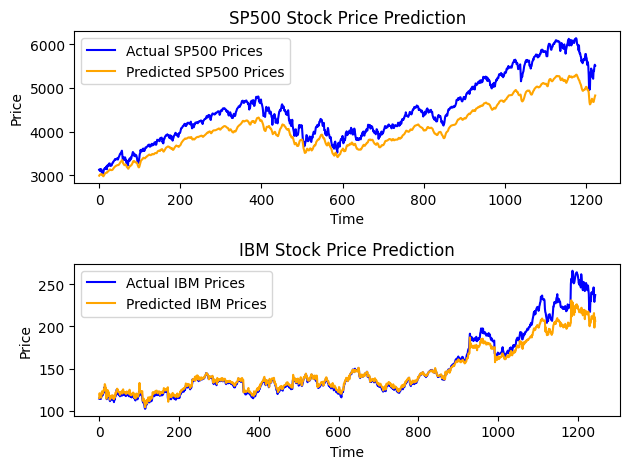

In [ ]:
# Sketch the results
# plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y_test_sp500, label='Actual SP500 Prices', color='blue')
plt.plot(y_pred_sp500, label='Predicted SP500 Prices', color='orange')
plt.title('SP500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test_ibm, label='Actual IBM Prices', color='blue')
plt.plot(y_pred_ibm, label='Predicted IBM Prices', color='orange')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
# plt.savefig('stock_price_prediction.png')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error


def evaluate_model(y_actual, y_pred,model_name='Model'):
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
    print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

In [ ]:
for ticker, y_test, y_pred in zip(['SP500', 'IBM'], [y_test_sp500, y_test_ibm], [y_pred_sp500, y_pred_ibm]):
    evaluate_model(y_test, y_pred, model_name=f"{ticker} LSTM Model")

SP500 LSTM Model - MSE: 193953.0469, MAE: 399.5040, MAPE: 8.52%
IBM LSTM Model - MSE: 103.7740, MAE: 5.7999, MAPE: 3.12%


In [ ]:
ibm_config = ibm_logger_sorted[5]